In [1]:
%pylab inline

import os
import pandas as pd
import itertools as it
from collections import OrderedDict
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from tools.EW import equivalent_width
from tools.Photometry import ABmag
from tools.stats import norm2one
from tools.issag import *
from scipy.ndimage import gaussian_filter
from scipy.stats import expon
from scipy.interpolate import Rbf

import seaborn as sns
from styles import slides

sns.set(style="ticks", palette="muted", color_codes=True, font_scale=1.4)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def cf(tau_V, wlength):
    return exp(- tau_V * (wlength / 5500.0) ** (- 0.7))

In [3]:
rdir = os.path.expandvars("$HOME/Research/photometric-ew")

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

sdss_res = loadtxt("{}/data/SDSS_filters.txt".format(rdir))
sdss_res = [
    sdss_res[:47],
    sdss_res[47:47+89],
    sdss_res[47+89:47+89+75],
    sdss_res[47+89+75:47+89+75+89],
    sdss_res[47+89+75+89:]
]
jpas = open("{}/data/JPAS_filters.txt".format(rdir)).readlines()

mask = [False if item.startswith("#") else True for item in jpas]
jpas_res = []
for i in xrange(mask.count(False)):
    try:
        ini = mask.index(False); mask.remove(False)
        fin = mask.index(False)
        
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:fin+1+i]]))
        
    except ValueError:
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:]]))

In [4]:
# prepare SSAG run
ssag = iSSAG(size=10000)
# generate SSAG
ssag.set_all_seds(emission="both")
# extract SSPs parameters
wavelength = ssag.models.wavelength
metallicities = ssag.models.metallicities
ages = ssag.models.ages
# extract SSPs
ssps_nebular = ssag.models.ssps_nebular
ssps_stellar = ssag.models.ssps_stellar

# read SDSS data
ew_sdss = pd.read_csv("{}/data/photo-speclines.csv".format(rdir), index_col="FITS")
ew_sdss.dropna(axis="index", subset=["H_alpha", "u", "r"], inplace=True)

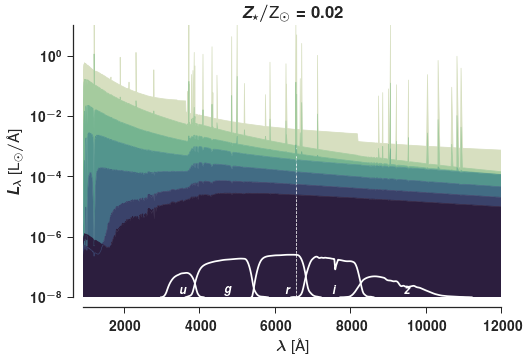

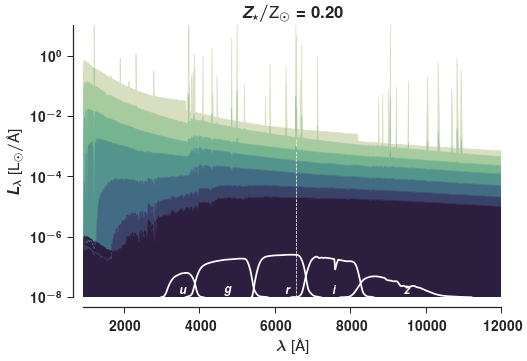

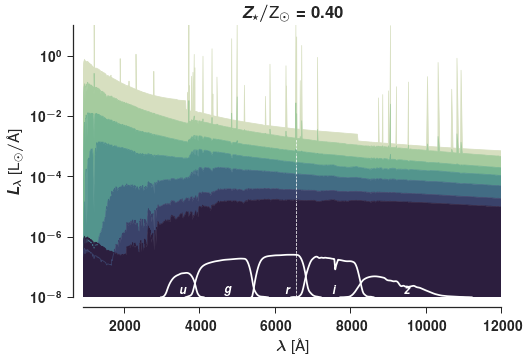

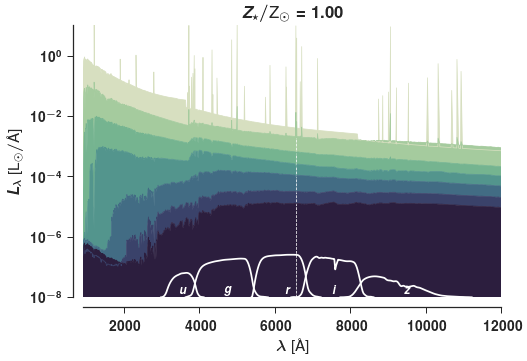

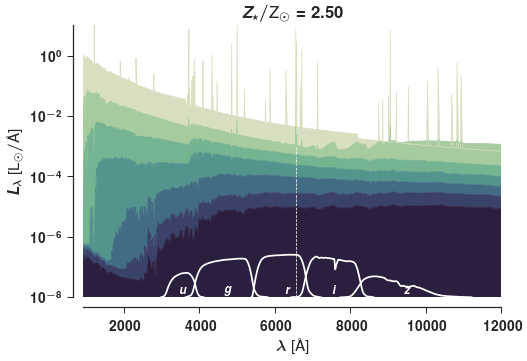

In [5]:
columns = ages[ages<=13e9][::10]#["10 Myr","50 Myr","200 Myr","1000 Myr", "13000 Myr"]
colors = sns.cubehelix_palette(columns.size, start=.5, rot=-.75)#cm.rainbow(linspace(0,1,len(columns)))

band_nms = [r"$u$",r"$g$",r"$r$",r"$i$",r"$z$"]

for k in xrange(metallicities.size):
    fig, ax = subplots(1, 1, figsize=(7.5,5))
    sns.despine(offset=10)
    ax.set_yscale("log")

    ssp_nebular = ssps_nebular[metallicities[k]]
    ssp_sel = ssp_nebular.get(columns).values
    for j in xrange(len(columns)):
        if j<len(columns)-1:
            ax.fill_between(wavelength, ssp_sel[:,j], ssp_sel[:,j+1], facecolor=colors[j], lw=0)
        else:
            ax.fill_between(wavelength, ssp_sel[:,j], 1e-35, facecolor=colors[j], lw=0)
        ax.plot(wavelength, ssp_sel[:,j], color=colors[j], lw=0.75, zorder=999)
    for i,band in enumerate(sdss_res):
        ax.plot(band[:,0], (band[:,1])/0.2e7+1e-8, color="w")
        ax.text((band[0,0]+band[-1,0])*0.5, 1.15e-8, band_nms[i], va="bottom", ha="center", color="w", size="x-small")
    ax.axvline(6562, lw=0.75, ls="--", color="w")
    ax.set_xlim(912,12000)
    ax.set_ylim(1e-8,10)
    ax.set_title(r"$Z_\star/\text{Z}_\odot=%.2f$"%(metallicities[k]))
    ax.set_xlabel(r"$\lambda$ [\AA]")
    ax.set_ylabel(r"$L_\lambda$ [L$_{\odot}/$\AA]")

In [6]:
# First Approach to the colour-EW correlation
# In rest-frame, compute the SDSS colours & equivalent widths
ur_neb = OrderedDict()
ur_ste = OrderedDict()
ew_neb = OrderedDict()
ur_exc = OrderedDict()
for Z in metallicities:
    ssp_nebular = ssps_nebular[Z]
    ssp_stellar = ssps_stellar[Z]
    
    ur_neb[Z], ur_ste[Z], ew_neb[Z] = [], [], []
    for j in xrange(ages.size):
        SED_neb_j = column_stack((wavelength, ssp_nebular.get(ages[j])))
        SED_ste_j = column_stack((wavelength, ssp_stellar.get(ages[j])))

        ur_neb[Z] += [ABmag(SED_neb_j, sdss_res[1]) - ABmag(SED_neb_j, sdss_res[3])]
        ur_ste[Z] += [ABmag(SED_ste_j, sdss_res[1]) - ABmag(SED_ste_j, sdss_res[3])]
        ew_neb[Z] += [equivalent_width(SED_neb_j, (6562,), (40,))[0]]
    # Compute the colour excess
    ur_neb[Z], ur_ste[Z], ew_neb[Z] = array(ur_neb[Z]), array(ur_ste[Z]), array(ew_neb[Z])
    ur_exc[Z] = ur_ste[Z] - ur_neb[Z]

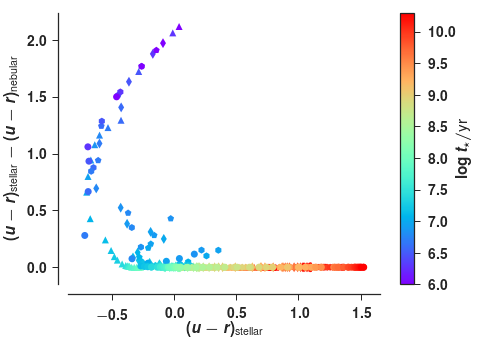

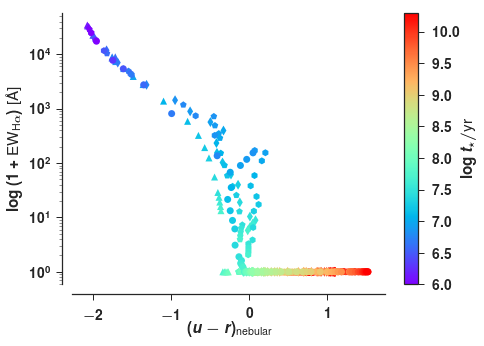

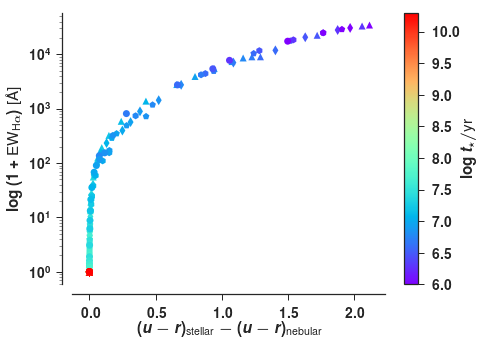

In [7]:
markers = OrderedDict(zip(metallicities,["^","d","p","h","o"]))

# Plot the colour vs the colour-excess (this should show an anti-correlation)
figure(figsize=(7,5))
for Z in metallicities: scatter(ur_ste[Z], ur_exc[Z], marker=markers[Z], c=log10(ages), lw=0, cmap=cm.rainbow)
sns.despine(offset=10)
cb = colorbar()
xlabel(r"$(u-r)_\text{stellar}$")
ylabel(r"$(u-r)_\text{stellar}-(u-r)_\text{nebular}$")
cb.set_label(r"$\log{t_\star/\text{yr}}$")

figure(figsize=(7,5))
for Z in metallicities: scatter(ur_neb[Z], 1+ew_neb[Z], marker=markers[Z], c=log10(ages), lw=0, cmap=cm.rainbow)
sns.despine(offset=10)
cb = colorbar()
xlabel(r"$(u-r)_\text{nebular}$")
gca().set_yscale("log")
ylabel(r"$\log{\left(1+\text{EW}_{\text{H}\alpha}\right)}$ [\AA]")
cb.set_label(r"$\log{t_\star/\text{yr}}$")

figure(figsize=(7,5))
for Z in metallicities: scatter(ur_exc[Z], 1+ew_neb[Z], marker=markers[Z], c=log10(ages), lw=0, cmap=cm.rainbow)
sns.despine(offset=10)
cb = colorbar()
xlabel(r"$(u-r)_\text{stellar}-(u-r)_\text{nebular}$")
gca().set_yscale("log")
ylabel(r"$\log{\left(1+\text{EW}_{\text{H}\alpha}\right)}$ [\AA]")
cb.set_label(r"$\log{t_\star/\text{yr}}$")

# This will help separate the age-nebular emission relation

In [8]:
# compute colours
ur_neb, ur_ste, ew_neb = [], [], []
for j in xrange(ssag.sample.index.size):
    SED_neb_j = column_stack((wavelength, ssag.seds_nebular.iloc[:,j]))
    SED_ste_j = column_stack((wavelength, ssag.seds_stellar.iloc[:,j]))

    ur_neb += [ABmag(SED_neb_j, sdss_res[1]) - ABmag(SED_neb_j, sdss_res[3])]
    ur_ste += [ABmag(SED_ste_j, sdss_res[1]) - ABmag(SED_ste_j, sdss_res[3])]
    ew_neb += [equivalent_width(SED_neb_j, (6562,), (40,))[0]]
# Compute the colour excess
ur_neb, ur_ste, ew_neb = array(ur_neb), array(ur_ste), array(ew_neb)
ur_exc = ur_ste - ur_neb

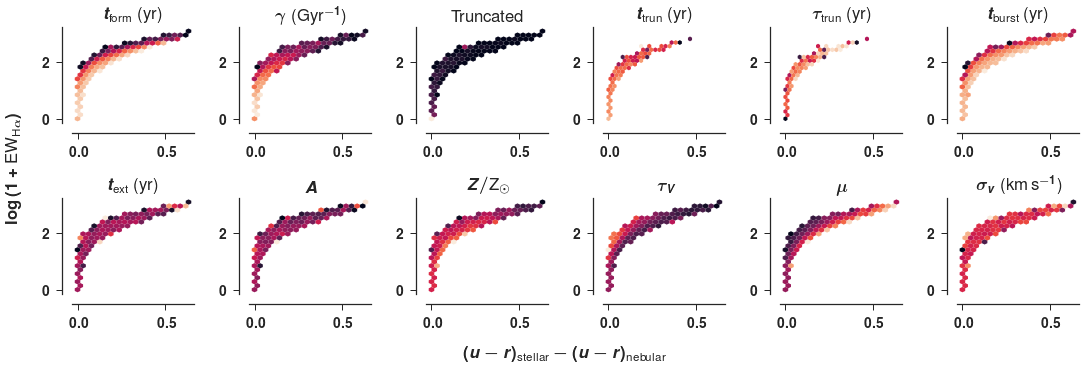

In [9]:
x, y = ur_exc, log10(1+ew_neb)
zs = (log10(ssag.sample.t_form),
      ssag.sample.gamma,
      ssag.sample.truncated,
      log10(ssag.sample.t_trun),
      log10(ssag.sample.tau_trun),
      log10(ssag.sample.t_burst),
      log10(ssag.sample.t_ext),
      ssag.sample.a_burst,
      ssag.sample.metallicity,
      ssag.sample.tau_v,
      ssag.sample.mu_v,
      ssag.sample.sigma_v)

labels = (
    r"$t_\text{form}$ (yr)",
    r"$\gamma$ (Gyr$^{-1}$)",
    r"Truncated",
    r"$t_\text{trun}$ (yr)",
    r"$\tau_\text{trun}$ (yr)",
    r"$t_\text{burst}$ (yr)",
    r"$t_\text{ext}$ (yr)",
    r"$A$",
    r"$Z/\text{Z}_\odot$",
    r"$\tau_V$",
    r"$\mu$",
    r"$\sigma_v$ (km\,s$^{-1}$)"
)

fig, axs = subplots(2, 6, figsize=(15,5), sharex=True, sharey=True)
axs = axs.ravel()
sns.despine(offset=10)

for i in xrange(axs.size):
    mask = ~isnan(zs[i])
#     interp = Rbf(x[mask], y[mask], zs[i][mask], function="linear")
#     zi = interp(xi, yi)
#     dy, dx = np.gradient(zi)
    
    sc = axs[i].hexbin(x, y, zs[i], 20, edgecolors=None)
#     axs[i].streamplot(xi, yi, dx, dy, color=zi, density=0.5, linewidth=1.0, arrowsize=0.5)
#     cb = colorbar(sc, ax=axs[i], orientation="horizontal")
    axs[i].set_title(labels[i])

# xlabel(r"$(u-r)_\text{stellar}-(u-r)_\text{nebular}$")
# ylabel(r"$\log{\left(1+\text{EW}_{\text{H}\alpha}\right)}$ [\AA]")
# cb.set_label(r"$\log{{t}_\text{burst}/\text{yr}}$")
fig.text(0.5, 0.0, r"$(u-r)_\text{stellar}-(u-r)_\text{nebular}$", ha="center", va="top")
fig.text(0.0, 0.5, r"$\log{\left(1+\text{EW}_{\text{H}\alpha}\right)}$", ha="right", va="center", rotation="vertical")
fig.tight_layout()

In [10]:
# x, y = ur_exc, log10(1+ew_neb)
# xi, yi = meshgrid(linspace(x.min(),x.max(),50), linspace(y.min(),y.max(),50), indexing="xy")
# zs = (log10(ssag.sample.t_form),
#       ssag.sample.gamma,
#       ssag.sample.truncated,
#       log10(ssag.sample.t_trun),
#       log10(ssag.sample.tau_trun),
#       log10(ssag.sample.t_burst),
#       log10(ssag.sample.t_ext),
#       ssag.sample.a_burst,
#       ssag.sample.metallicity,
#       ssag.sample.tau_v,
#       ssag.sample.mu_v,
#       ssag.sample.sigma_v)

# labels = (
#     r"$t_\text{form}$ (yr)",
#     r"$\gamma$ (Gyr$^{-1}$)",
#     r"Truncated",
#     r"$t_\text{trun}$ (yr)",
#     r"$\tau_\text{trun}$ (yr)",
#     r"$t_\text{burst}$ (yr)",
#     r"$t_\text{ext}$ (yr)",
#     r"$A$",
#     r"$Z/\text{Z}_\odot$",
#     r"$\tau_V$",
#     r"$\mu$",
#     r"$\sigma_v$ (km\,s$^{-1}$)"
# )

# fig, axs = subplots(2, 6, figsize=(15,5), sharex=True, sharey=True)
# axs = axs.ravel()
# sns.despine(offset=10)

# for i in xrange(axs.size):
#     mask = ~isnan(zs[i])
#     interp = Rbf(x[mask], y[mask], zs[i][mask], function="linear")
#     zi = interp(xi, yi)
#     dy, dx = np.gradient(zi)
    
#     axs[i].streamplot(xi, yi, dx, dy, color=zi, density=0.5, linewidth=1.0, arrowsize=0.5)
#     axs[i].set_title(labels[i])

# fig.tight_layout()